# Name: Tancredi Bosi
# ID number: 0001121897

### Submission for the Deep Learning project - 14/06/2024

# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The output can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [ ]:
!pip install datasets
!pip install --upgrade keras

# Import the libraries and set the seed

In [ ]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import keras
import keras.layers as layers
import keras.ops as ops
from difflib import SequenceMatcher
from keras.layers import TextVectorization, MultiHeadAttention, LayerNormalization
from tensorflow.keras.utils import Sequence
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import datetime
import random

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

2024-06-11 18:23:55.322896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 18:23:55.323044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 18:23:55.460437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

In [ ]:
# Given TextDetokenizer
class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
            if t == 3:
                s="<start>"
            elif t == 2:
                s="<end>"
            elif t == 7:
                s="<comma>"
            else:
                s=self.index_to_word.get(t, '[UNK]')
            return s
        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
        return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]

In [ ]:
# Given DataGenerator
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=128, shuffle=True, seed=42):

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
              np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

#### Download the dataset

In [ ]:
# Download the dataset
ds = load_dataset('generics_kb', trust_remote_code=True)['train']

# Filter the rows with lenght greater than 8
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8)

# Add a start and an end token and replace ',' with a token
corpus = ['<start> ' + row['generic_sentence'].replace(",", " <comma>") + ' <end>' for row in ds]
corpus = np.array(corpus)

# Create a tokenizer
tokenizer = TextVectorization(max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8", )
tokenizer.adapt(corpus)

# Create a detokenizer
detokenizer = TextDetokenizer(tokenizer)
sentences = tokenizer(corpus).numpy()

# Remove from corpus the sentences where any unknown word appears
mask = np.sum((sentences == 1), axis=1) >= 1
original_data = np.delete(sentences, mask, axis=0)

# Shuffle the all data with a random permutation of training and test set
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

#### Split the dataset

In [ ]:
# Train set
train_generator = DataGenerator(shuffled_data[:220000], 220000)
Xtrain, ytrain = train_generator.__getitem__(0)
labels = ytrain

# Set the DropOut rate

In [ ]:
dropout_rate = 0.1

# Model class
I used a Transformer, with Ecoder and Decoder exploiting the self-attention layers. This approach is the most used I think being the main architecture for text processing.

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=dropout_rate):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs, inputs) # Multi head attention where Key, Value and Query are all the same
        attn_output = self.dropout1(attn_output, training=training) # We add a dropout to reduce overfitting
        out1 = self.layernorm1(inputs + attn_output) # We add a residual connection and layernorm the result
        ffn_output = self.ffn(out1) # Feedforward network
        ffn_output = self.dropout2(ffn_output, training=training) # a second dropout
        return self.layernorm2(out1 + ffn_output) # a second residual connection

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # The embedding layer turns positive integers into dense vectors,
        # so that words with similar meaning are close to each other
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # get the number of tokens
        maxlen = tf.shape(x)[-1]
        # get all positions in order
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # then get the embedded positions
        positions = self.pos_emb(positions)
        # compute the token embeddings
        x = self.token_emb(x)
        # return the embedded tokens + the positions
        return x + positions

class TransformerEncoder(layers.Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, input_vocab_size, maximum_position_encoding, rate=dropout_rate):
        super().__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.token_emb = TokenAndPositionEmbedding(maxlen=maximum_position_encoding, vocab_size=input_vocab_size, embed_dim=embed_dim)
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)

    def call(self, inputs, training=True):
        x = self.token_emb(inputs)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)
        return self.dropout(x, training=training)

class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=dropout_rate):
        super().__init__()
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, enc_output, training=True):
        attn_output = self.att2(inputs, inputs, inputs, use_causal_mask=True) # Multi head attention where Key, Value and Query are all the same
        attn_output = self.dropout1(attn_output, training=training) # We add a dropout to reduce overfitting
        out1 = self.layernorm1(inputs + attn_output) # We add a residual connection and layernorm the result
        attn_output_2 = self.att1(out1,enc_output, enc_output)
        out2= self.layernorm2(attn_output_2 + out1)
        ffn_output = self.ffn(out2) # Feedforward network
        ffn_output = self.dropout2(ffn_output, training=training) # a second dropout
        return self.layernorm3(out2 + ffn_output) # a second residual connection

class TransformerDecoder(layers.Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, target_vocab_size, maximum_position_encoding, rate=dropout_rate):
        super().__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.token_emb = TokenAndPositionEmbedding(maxlen=maximum_position_encoding, vocab_size=target_vocab_size, embed_dim=embed_dim)
        self.dec_layers = [TransformerDecoderBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)

    def call(self, inputs, enc_output, training=True):
        attention_weights = {}
        x = self.token_emb(inputs)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training=training)
        return self.dropout(x, training=training)

class Transformer(keras.Model):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=dropout_rate):
        super().__init__()
        self.encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim, input_vocab_size, pe_input, rate)
        self.decoder = TransformerDecoder(num_layers, embed_dim, num_heads, ff_dim, target_vocab_size, pe_target, rate)
        self.final_layer = layers.Dense(target_vocab_size)

    def call(self, inputs,training=True):
        x,y=inputs
        enc_output = self.encoder(x, training=training)
        dec_output = self.decoder(y, enc_output, training=training)
        final_output = self.final_layer(dec_output)
        return final_output

# Set the parameters and create the model
Define the model to use with the tuned hyperparameters.
The hyperparameters chosen are obtained through a sequence of trials of training. Hyperparameters:
- number of encoder layers: 6
- number of decoder layers: 6
- number of heads: 8
- embedding size: 128
- dimension of FNN layers: 256

Using a network with 6 encorders and 6 decoders was the choice that made my network work better. Also the number of heads increased a lot the performances, so I set it to 8. Increasing the dimension of the embeddings would improve a lot the performances, but it would also increase the dimension of the parameters to train too much; therefore I decided to keep it to 128. The dimension of the FNN layers does not increase too much the dimension of the model, so I chose a solid 256.

### Performances
With these hyperparameters I obtained a **score of 0.5007 on 5k sentences** of the shuffled test set. This result is therefore obtained with a model that has **14.1 million parameters**.

### Other architectures
Increasing the model dimensions was still improving the score, reaching 0.52 with a 19.9M parameters model, but I decided to prefer a **smaller and faster model** to make a more reasonable choice for a real case scenario, where 5 million less parameters can make the difference.

In [ ]:
# Number of encoders and decoders
num_layers = 6

# Dimension of the embedding
embed_dim = 128

# Number of heads
num_heads = 8

# Dimension of the FNN layers
ff_dim = 256

# Size of input and output vocabularies
input_vocab_size = 10000
target_vocab_size = 10000

# Maximum position encodings
pe_input = 28
pe_target = 28

# Create the transformer model
model = Transformer(num_layers, embed_dim, num_heads, ff_dim, input_vocab_size, target_vocab_size, pe_input, pe_target)

# Create the optimizer
The Adam optimizer is used with some changes in the parameters to better use the schedule for the learning rate. The Learning Rate Schedule is from an example of keras website.

In [ ]:
# Create a class for a Learning Rate Schedule
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Create the learning rate
learning_rate = CustomSchedule(embed_dim)

# Create the optimizer with Adam
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Create custom loss and accuracy
Definition of a custom loss and accuracy that improve the training performances working directly on the tokens, and therefore being more reliable to monitor.

In [ ]:
K_VALUE = 0.97
max_sequence_len = 28

# Define a custom loss function that works directly on tokens
def custom_masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    a = tf.cast(tf.range(1, max_sequence_len + 1), tf.float32)
    constant_val = tf.constant(K_VALUE)
    final_array = tf.pow(constant_val, a)

    mask = tf.cast(mask, dtype=loss.dtype)
    mask *= final_array

    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

# Define a custom metric that works directly on tokens
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)

    mask = tf.cast(mask, dtype=tf.float32)

    return tf.reduce_sum(match) / tf.reduce_sum(mask)

# Compile the model with callbacks and the necessary parameters

The only callback used is the EarlyStopping monitoring the validaton loss. I tried also with `restore_best_weights=True`, but it performed worse with different networks.



In [ ]:
# Set the batch size
BATCH_SIZE = 512
vocab_size = 10000

# Create an EarlyStopping callback monitoring the val_accuracy
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

src = tf.random.uniform((BATCH_SIZE, max_sequence_len), dtype=tf.int64, minval=0, maxval=vocab_size)
trg = tf.random.uniform((BATCH_SIZE, max_sequence_len), dtype=tf.int64, minval=0, maxval=vocab_size)
model((src,trg))

# Compile the model
model.compile(optimizer=optimizer, loss=[custom_masked_loss], metrics=[masked_accuracy])
model.summary()

# Remove the first element of each row
sliced_array = labels[:, 1:]

# Append a column of zeros
ordered_sentences_shifted = np.hstack((sliced_array, np.zeros((sliced_array.shape[0], 1),dtype=int)))

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ transformer_encoder             │ ?                      │     4,847,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder             │ ?                      │     8,013,568 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │     1,290,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,150,672 (53.98 MB)

 Trainable params: 14,150,672 (53.98 MB)

 Non-trainable params: 0 (0.00 B)

Fit the model (the number of epochs is set to an high number, but it always stops around 20 - 30 epochs with EarlyStopping)

In [ ]:
# Fit the model on the training set
history = model.fit(x = (Xtrain, ytrain),
                    y = ordered_sentences_shifted,
                    batch_size = BATCH_SIZE,
                    epochs=75,
                    callbacks=[es],
                    validation_split=0.1)

Epoch 1/75


I0000 00:00:1718130536.702608      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718130536.787702      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - loss: 8.7485 - masked_accuracy: 0.0584

W0000 00:00:1718130703.655397      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


387/387 ━━━━━━━━━━━━━━━━━━━━ 287s 467ms/step - loss: 8.7468 - masked_accuracy: 0.0585 - val_loss: 6.6719 - val_masked_accuracy: 0.2241
Epoch 2/75
387/387 ━━━━━━━━━━━━━━━━━━━━ 108s 278ms/step - loss: 6.1456 - masked_accuracy: 0.2621 - val_loss: 4.7105 - val_masked_accuracy: 0.3700
Epoch 3/75
387/387 ━━━━━━━━━━━━━━━━━━━━ 142s 277ms/step - loss: 4.4126 - masked_accuracy: 0.3968 - val_loss: 3.3065 - val_masked_accuracy: 0.5228
Epoch 4/75
387/387 ━━━━━━━━━━━━━━━━━━━━ 108s 278ms/step - loss: 3.1531 - masked_accuracy: 0.5352 - val_loss: 2.2867 - val_masked_accuracy: 0.6391
Epoch 5/75
387/387 ━━━━━━━━━━━━━━━━━━━━ 142s 278ms/step - loss: 2.2455 - masked_accuracy: 0.6353 - val_loss: 1.6743 - val_masked_accuracy: 0.7019
Epoch 6/75
387/387 ━━━━━━━━━━━━━━━━━━━━ 108s 278ms/step - loss: 1.6675 - masked_accuracy: 0.6950 - val_loss: 1.3101 - val_masked_accuracy: 0.7384
Epoch 7/75
387/387 ━━━━━━━━━━━━━━━━━━━━ 108s 278ms/step - loss: 1.3258 - masked_accuracy: 0.7298 - val_loss: 1.1638 - val_masked_accura

Save the weights

In [ ]:
model.save_weights(f'weights_tancredi_bosi.weights.h5')

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()

  return (match.size/max(len(p),len(s)))

The score is computed on the test set that is already shuffled. I decided to compute the score on 5k sentences to have a robust value, and I calculated it in batches of 1k sentences to make the process faster.

In [ ]:
# Create a function that decodes the sentences in order to be able to make predictions
def decode_sentence(input_sentences, max_length=28):
    batch_size = tf.shape(input_sentences)[0]
    encoder_input = input_sentences
    decoded_indexes = [[3] for _ in range(batch_size)]

    for i in range(1, max_length):
        decoder_input = tf.convert_to_tensor(decoded_indexes)
        predictions = np.array(model((np.array(encoder_input), np.array(decoder_input)), training=False))
        predictions = predictions[:, -1, :]
        for j in range(batch_size):
            best_index = np.argmax(predictions[j])
            decoded_indexes[j].append(best_index)

    return decoded_indexes

# Load the test set (only 'total' sentences)
detokenizer = TextDetokenizer(tokenizer)
batch_size = 1000
total = 5000
testset = DataGenerator(shuffled_data[220000:], batch_size=total)
shuffled_sentences_test, original_sentences_test = testset.__getitem__(0)

# Make predictions of all the test set sentences
# and append the intermediate results in the list 'all_scores'
all_scores = []
for i in range(total//batch_size):
    shuffled_sentences = shuffled_sentences_test[i*batch_size:(i+1)*batch_size]
    original_sentences = original_sentences_test[i*batch_size:(i+1)*batch_size]
    translated_sentences = decode_sentence(shuffled_sentences)

    detokenized_predictions = detokenizer(translated_sentences)
    detokenized_labels = detokenizer(original_sentences)

    all_scores += [score(single_original.replace("<start>", "").replace("<end>", "").replace(" <comma>", ",").strip(), single_translated.replace("<start>", "").replace("<end>", "").replace(" <comma>", ",").strip()) for single_original, single_translated in zip(detokenized_labels, detokenized_predictions)]
    print(f"\nComputed: {len(all_scores)}; Score: {np.mean(all_scores)} \n")
    print('-------------------------------')

# Print the average score over all the test set 'total' elements
print('\n')
print('AVERAGE SCORE OVER', total, 'ELEMENTS:', sum(all_scores)/len(all_scores))

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1000, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Computed: 1000; Score: 0.5046563162023712 

-------------------------------

Computed: 2000; Score: 0.5009717488009906 

-------------------------------

Computed: 3000; Score: 0.49879653211544805 

-------------------------------

Computed: 4000; Score: 0.49947771227995613 

-------------------------------

Computed: 5000; Score: 0.5007268192200046 

-------------------------------


AVERAGE SCORE OVER 5000 ELEMENTS: 0.5007268192200035


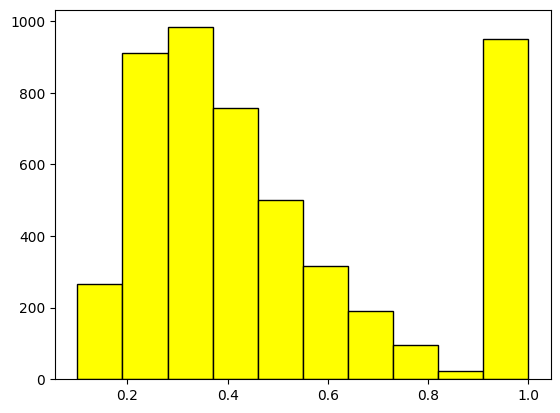

In [ ]:
plt.hist(all_scores, color='yellow', edgecolor='black', bins=10)
plt.show()